# Generation of synthetic trajectories using the previously calculated medoids as starting and ending points.
We also interpolate trajectories and calculate timedeltas between each point in order to fake a realistic trajectory according to various mobility profiles.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml

with open("./conf.yaml") as f:
    conf = yaml.load(f, Loader = yaml.FullLoader)
    
data_path = conf["data_path"]
    
medoids = pd.read_csv(data_path + "medoids.csv")
print(medoids.head())

   index             datetime        lat         lng  uid  \
0     85  2008-06-22 01:53:33  39.975428  116.330495    0   
1     59  2008-06-15 11:14:26  39.984828  116.303761    0   
2      6  2008-06-03 05:22:48  39.984988  116.352642    0   
3    300  2008-08-11 16:21:21  40.006256  116.320507    0   
4    311  2008-08-13 19:02:24  40.030552  116.409093    0   

      leaving_datetime  cluster  
0  2008-06-22 04:01:07        0  
1  2008-06-15 12:50:11        1  
2  2008-06-03 08:08:27        2  
3  2008-08-11 23:34:28        3  
4  2008-08-13 20:33:27        4  


After correctly reading the csv, we try to create a single trajectory

In [2]:
import osmnx as ox

med_0 = (medoids.iloc[0].lat, medoids.iloc[0].lng)
med_8 = (medoids.iloc[8].lat, medoids.iloc[8].lng)
print("Starting medoid: " + str(med_0))
print("Arrival medoid: " + str(med_8))

Starting medoid: (39.9754283, 116.33049495)
Arrival medoid: (39.91280415, 116.61326245)


We plot the two medoids on Beijing's map:

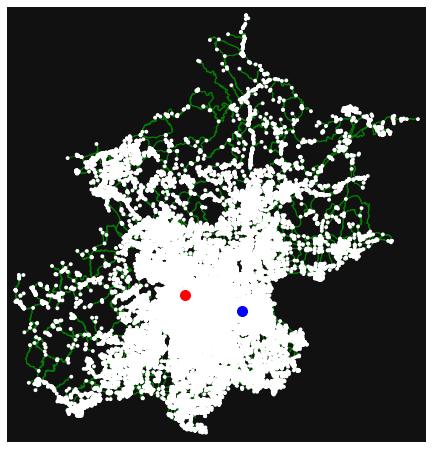

In [3]:
#obtaining Beijing's drive map
G = ox.graph_from_place('Beijing, China', which_result=2, network_type='drive')

fig, ax = ox.plot_graph(G, 
                        show=False, close=False, 
                        edge_color="green")
ax.scatter(med_0[1], med_0[0], c="red", s=100)
ax.scatter(med_8[1], med_8[0], c="blue", s=100)
plt.show()

We need to find the closest points to our medoids in the graph in order to calculate the shortest path between them

In [4]:
from sklearn.neighbors import KDTree

gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

tree = KDTree(gdf_nodes[['y', 'x']], metric='euclidean')

med_0_idx = tree.query([med_0], k=1, return_distance=False)[0]
med_8_idx = tree.query([med_8], k=1, return_distance=False)[0]

closest_node_to_0 = gdf_nodes.iloc[med_0_idx].index.values[0]
closest_node_to_8 = gdf_nodes.iloc[med_8_idx].index.values[0]

Now we try to calculate the shortest path between these two points

In [5]:
import networkx as nx

path = nx.shortest_path(G, 
                         closest_node_to_0,
                         closest_node_to_8,
                         weight='length')
#gdf_nodes.loc[path]

print (nx.shortest_path_length(G, 
                         closest_node_to_0,
                         closest_node_to_8,
                         weight='length'))

print(path)

29576.09500000001
[1989838157, 1989838154, 1989838152, 1989838153, 586470726, 240420386, 1687193515, 1687193488, 2264122510, 2264122507, 529493691, 331146382, 2273021641, 35863261, 586468682, 2273021640, 2363166319, 2272994448, 529348230, 529348228, 746856539, 266114471, 529348195, 265710786, 1790342384, 1748306006, 1816181325, 1748305999, 7103268488, 7103268487, 1748306000, 1767304560, 1350995984, 529365636, 529365476, 7103231569, 7103231570, 746856608, 250458383, 529504071, 746856352, 529365348, 1747714935, 324664761, 1747714907, 324664304, 237537263, 290598471, 1747703950, 340250354, 1356404788, 324664067, 324664065, 1356404774, 64367553, 32618816, 1742785935, 342731517, 528867992, 32388365, 269491225, 269491787, 269491782, 269491201, 342836138, 1624163744, 342837357, 342837974, 342838703, 1976889034, 1976889011, 733788697, 733858971, 733859948, 733858800, 733859080, 1860131873, 733858841, 340256161, 340256168, 340256169, 266111576, 266111556, 1449318349, 1449318326, 76457683, 35305

Let's print the path on the graph and then on a folium map:

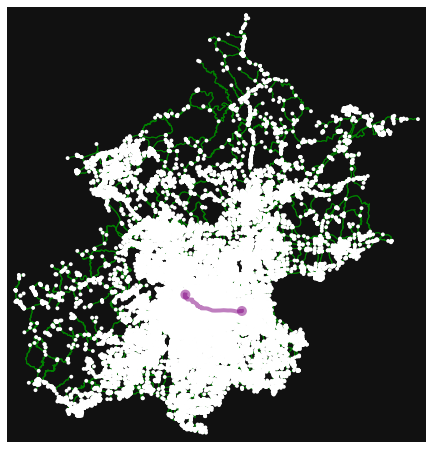

In [6]:
fig, ax = ox.plot_graph_route(G, path, 
                              show=False, close=False, 
                              edge_color='green',
                              route_color="purple")
plt.show()

In [7]:
import folium

m = ox.plot_route_folium(G, path, route_color='green')
folium.Marker(location=med_0,
              icon=folium.Icon(color="red")).add_to(m)
folium.Marker(location=med_8,
              icon=folium.Icon(color='blue')).add_to(m)
m

Now let's try and add interpolation to get dense trajectories.
First we show our path and relative geodataframe.

In [8]:
gdf = gdf_nodes.loc[path]

print(gdf.head())
print(len(gdf))

                    y           x       osmid  ref          highway  \
1989838157  39.975353  116.330435  1989838157  NaN              NaN   
1989838154  39.975220  116.330425  1989838154  NaN              NaN   
1989838152  39.975154  116.330421  1989838152  NaN              NaN   
1989838153  39.975173  116.329066  1989838153  NaN              NaN   
586470726   39.975192  116.327668   586470726  NaN  traffic_signals   

                              geometry  
1989838157  POINT (116.33043 39.97535)  
1989838154  POINT (116.33043 39.97522)  
1989838152  POINT (116.33042 39.97515)  
1989838153  POINT (116.32907 39.97517)  
586470726   POINT (116.32767 39.97519)  
167


We're ready to try interpolation on our points, in order to to so we employ geographiclib.
We try and get a point every k meters (i.e. 100m).

If we put 10m everything would just explode because of folium, this is just for demo purposes.

In [9]:
from geographiclib.geodesic import Geodesic
import math

m = folium.Map(tiles="Stamen Toner", zoom_start=2)

k = 100 #interpolation offset, over k meters generate lon lat

geod = Geodesic.WGS84

for i in range(len(gdf) - 1):
    
    l = geod.InverseLine(gdf.iloc[i].y, gdf.iloc[i].x, gdf.iloc[i+1].y, gdf.iloc[i+1].x)
    ds = k; n = int(math.ceil(l.s13 / ds))
    for i in range(n + 1):
        #if i == 0:
            #print( "distance latitude longitude azimuth")
        s = min(ds * i, l.s13)
        g = l.Position(s, Geodesic.STANDARD | Geodesic.LONG_UNROLL)
        folium.Marker([g["lat2"], g["lon2"]]).add_to(m)
        #print ("{:.0f} {:.5f} {:.5f} {:.5f}".format(
        #    g['s12'], g['lat2'], g['lon2'], g['azi2']))


m